In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("/Users/erion/Desktop/MSCF2/ADA/Capstone-Project/data/processed/modeling_dataset.csv", index_col=0, parse_dates=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
print(df.head())

Dataset shape: (5469, 43)
Date range: 2004-01-13 to 2024-12-27
                gold    eurusd  treasury_10y       spy       vix       dxy  \
Date                                                                         
2004-01-13 -0.006099  0.003529         4.028 -0.005830  0.072533 -0.000468   
2004-01-14 -0.004720 -0.010551         3.986  0.008351 -0.071508  0.006081   
2004-01-15 -0.031539 -0.003957         3.971  0.002468 -0.071045  0.006161   
2004-01-16 -0.004163 -0.016105         4.014  0.003955 -0.035990  0.013517   
2004-01-19  0.000000 -0.003546         4.014  0.000000  0.000000 -0.000798   

                 oil    target  gold_lag1  gold_lag2  ...  vix_lag3  dxy_lag1  \
Date                                                  ...                       
2004-01-13 -0.008353 -0.004720  -0.000235   0.005660  ...  0.007097  0.005170   
2004-01-14  0.002033 -0.031539  -0.006099  -0.000235  ...  0.073030 -0.000468   
2004-01-15 -0.030725 -0.004163  -0.004720  -0.006099  ...  0.00417

# ML Models: Random Forest & XGBoost

Comparing traditional machine learning approaches on 2016 test set (first out-of-sample year)

## Data Loading & Preparation

In [18]:
# Train-test split: 2003-2015 train, 2016 test
train = df.loc[:'2015-12-31'].copy()
test  = df.loc['2016-01-01':'2016-12-31'].copy()

X_train = train.drop(columns=['target'])
y_train = train['target']

X_test = test.drop(columns=['target'])
y_test = test['target']

print(f"Training set: {train.index[0].date()} to {train.index[-1].date()} ({len(X_train)} rows)")
print(f"Test set: {test.index[0].date()} to {test.index[-1].date()} ({len(X_test)} rows)")
print(f"Features: {X_train.shape[1]}")

Training set: 2004-01-13 to 2015-12-31 (3123 rows)
Test set: 2016-01-01 to 2016-12-30 (261 rows)
Features: 42


In [19]:
# Feature scaling for Random Forest (not strictly necessary but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete")

Feature scaling complete


## Model 1: Random Forest

In [20]:
# Initialize Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42
)

# Fit the model
rf.fit(X_train_scaled, y_train)

# Predict on test set
rf_pred = rf.predict(X_test_scaled)

# Compute metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
mae_rf = mean_absolute_error(y_test, rf_pred)
dir_acc_rf = (np.sign(rf_pred) == np.sign(y_test)).mean() * 100

print("=" * 60)
print("RANDOM FOREST PERFORMANCE")
print("=" * 60)
print(f"RMSE: {rmse_rf:.6f}")
print(f"MAE:  {mae_rf:.6f}")
print(f"Directional Accuracy: {dir_acc_rf:.2f}%")
print(f"Test samples: {len(y_test)}")

RANDOM FOREST PERFORMANCE
RMSE: 0.009988
MAE:  0.006987
Directional Accuracy: 45.21%
Test samples: 261


## Model 2: XGBoost

In [21]:
from xgboost import XGBRegressor

# Initialize XGBoost model
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Fit model (XGBoost does not need scaled data)
xgb.fit(X_train, y_train)

# Predict on test set
xgb_pred = xgb.predict(X_test)

# Compute metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
mae_xgb = mean_absolute_error(y_test, xgb_pred)
dir_acc_xgb = (np.sign(xgb_pred) == np.sign(y_test)).mean() * 100

print("=" * 60)
print("XGBOOST PERFORMANCE")
print("=" * 60)
print(f"RMSE: {rmse_xgb:.6f}")
print(f"MAE:  {mae_xgb:.6f}")
print(f"Directional Accuracy: {dir_acc_xgb:.2f}%")
print(f"Test samples: {len(y_test)}")

XGBOOST PERFORMANCE
RMSE: 0.010455
MAE:  0.007449
Directional Accuracy: 48.28%
Test samples: 261


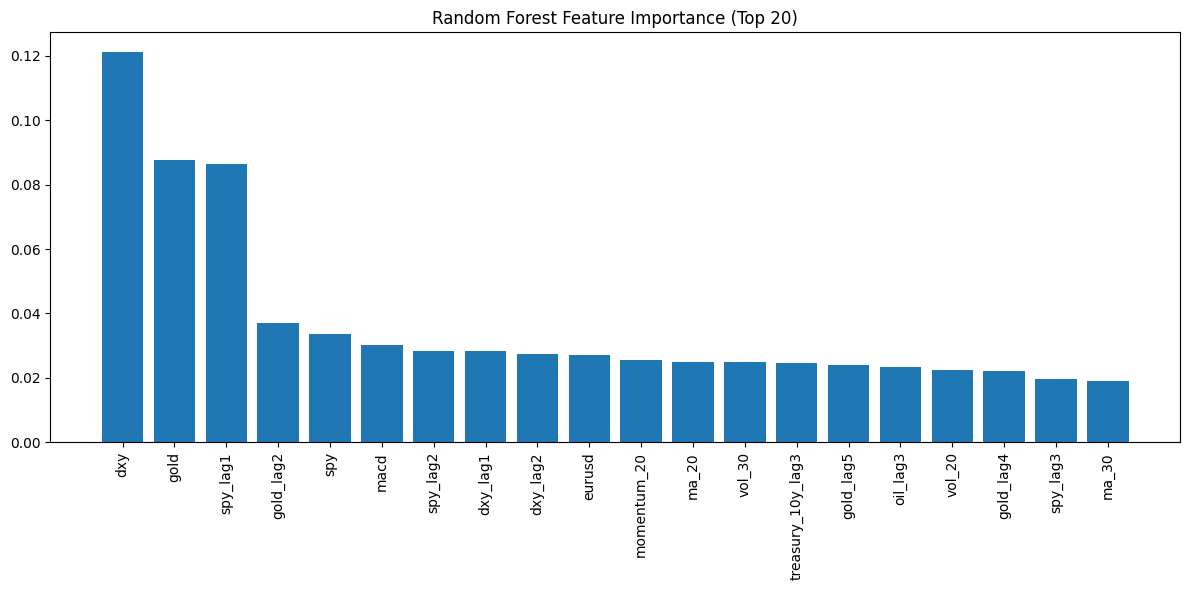

In [22]:
importances = rf.feature_importances_
feature_names = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Random Forest Feature Importance (Top 20)")
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), feature_names[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

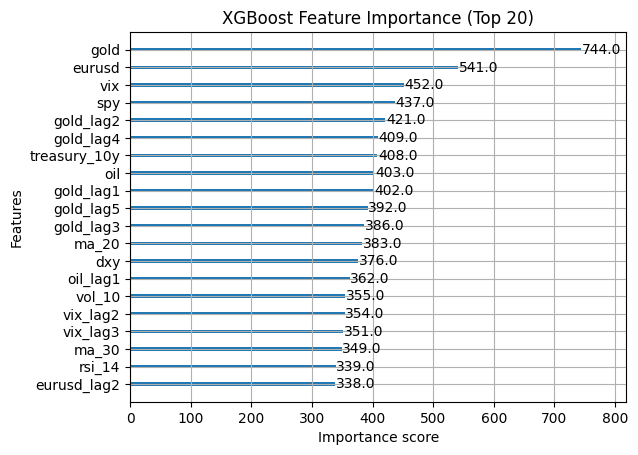

In [23]:
from xgboost import plot_importance

plt.figure(figsize=(10,8))
plot_importance(xgb, max_num_features=20)
plt.title("XGBoost Feature Importance (Top 20)")
plt.show()

In [24]:
# ML results
results_ml = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "RMSE": [rmse_rf, rmse_xgb],
    "MAE": [mae_rf, mae_xgb],
    "Dir. Accuracy %": [dir_acc_rf, dir_acc_xgb]
})

# Baseline results from Notebook 05
baseline_results = pd.DataFrame({
    "Model": ["Naive (gold_lag1)", "SMA (20-day)", "ARIMA(1,0,1)"],
    "RMSE": [0.013904, 0.010116, 0.010013],
    "MAE": [0.010316, 0.007015, 0.006982],
    "Dir. Accuracy %": [45.98, 49.04, 46.74]
})

# Combine all results
all_results = pd.concat([baseline_results, results_ml], ignore_index=True)

print("\n" + "=" * 90)
print("FULL MODEL COMPARISON (2016 Test Set - First Out-of-Sample Year)")
print("=" * 90)
print(all_results.to_string(index=False))
print("=" * 90)

# Ranking
print("\nRanking by RMSE (lower is better):")
ranked = all_results.sort_values('RMSE').reset_index(drop=True)
for i, row in ranked.iterrows():
    print(f"{i+1}. {row['Model']:20s}: RMSE={row['RMSE']:.6f}, MAE={row['MAE']:.6f}, Dir.Acc={row['Dir. Accuracy %']:.2f}%")



FULL MODEL COMPARISON (2016 Test Set - First Out-of-Sample Year)
            Model     RMSE      MAE  Dir. Accuracy %
Naive (gold_lag1) 0.013904 0.010316        45.980000
     SMA (20-day) 0.010116 0.007015        49.040000
     ARIMA(1,0,1) 0.010013 0.006982        46.740000
    Random Forest 0.009988 0.006987        45.210728
          XGBoost 0.010455 0.007449        48.275862

Ranking by RMSE (lower is better):
1. Random Forest       : RMSE=0.009988, MAE=0.006987, Dir.Acc=45.21%
2. ARIMA(1,0,1)        : RMSE=0.010013, MAE=0.006982, Dir.Acc=46.74%
3. SMA (20-day)        : RMSE=0.010116, MAE=0.007015, Dir.Acc=49.04%
4. XGBoost             : RMSE=0.010455, MAE=0.007449, Dir.Acc=48.28%
5. Naive (gold_lag1)   : RMSE=0.013904, MAE=0.010316, Dir.Acc=45.98%
